<a href="https://colab.research.google.com/github/aligilbert/AliData/blob/master/SeasonalTrendsTimeSeriesCO2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [196]:
from pickle import FALSE # This import is not necessary
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn import linear_model


# Load the dataset
file_path = '/content/CO2_3.csv'
df = pd.read_csv(file_path)

# Adding a column for t_i
df['t_i'] = (np.arange(len(df)) + 0.5) / 12
# Cleaning the data by dropping rows with missing values (-99.99) in the CO2 column
df_cleaned = df[df.iloc[:, 1] != -99.99].copy()


# Extracting the relevant columns: CO2 concentration and t_i
# df_cleaned.columns = df_cleaned['CO2', 't_i'] # Incorrect way to rename columns
df_cleaned = df_cleaned[['CO2', 't_i']] # Select the desired columns

# Splitting the data into training and test sets (80:20 split)
train_data, test_data = train_test_split(df_cleaned, test_size=0.2, shuffle = False) # Use boolean False

# Fitting the training data to a simple linear model F_1(t) ~ α_0 + α_1*t
X_train = train_data['t_i'].values.reshape(-1, 1)
y_train = train_data['CO2'].values

model = LinearRegression()
model.fit(X_train, y_train)

alpha_0_hat = model.intercept_
alpha_1_hat = model.coef_[0]

# Predictions on the test set
X_test = test_data['t_i'].values.reshape(-1, 1)
y_test = test_data['CO2'].values
y_pred = model.predict(X_test)

# Calculating RMSE and MAPE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)

# Reporting the values of α_0_hat and α_1_hat
print(f'α_0_hat: {alpha_0_hat:.2f}')
print(f'α_1_hat: {alpha_1_hat:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.2%}')

α_0_hat: 308.99
α_1_hat: 1.41
RMSE: 10.64
MAPE: 2.45%


In [197]:
df.head()

,Date,CO2,Mn,t_i
0,1958.0411,-99.99,1,0.041667
1,1958.1260,-99.99,2,0.125000
2,1958.2027,315.70,3,0.208333
3,1958.2877,317.45,4,0.291667
4,1958.3699,317.51,5,0.375000


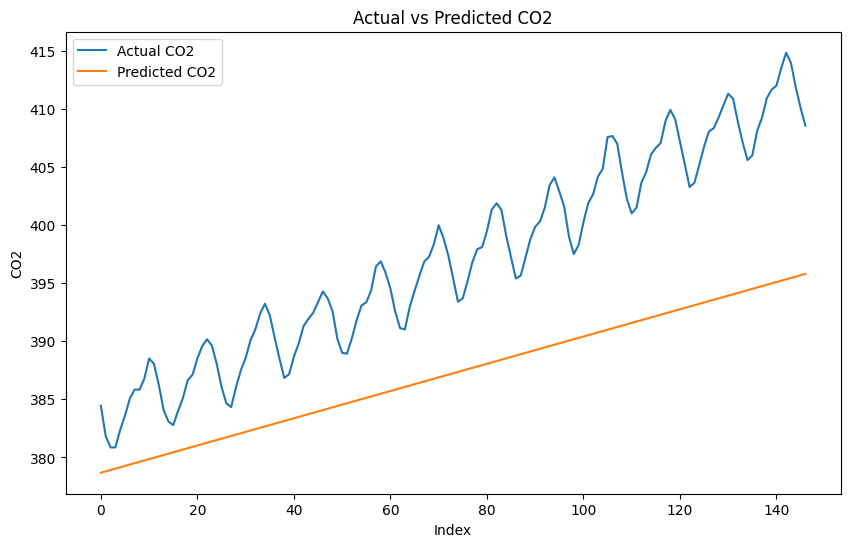

In [198]:
# prompt: plot model

import matplotlib.pyplot as plt

# Plot the actual and predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual CO2')
plt.plot(y_pred, label='Predicted CO2')
plt.xlabel('Index')
plt.ylabel('CO2')
plt.title('Actual vs Predicted CO2')
plt.legend()
plt.show()

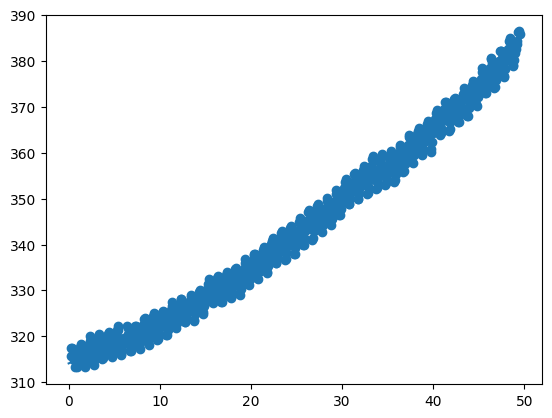

         2
0.01212 x + 0.8021 x + 314.1


In [199]:
# degree 2 polynomial fit or quadratic fit
model = np.poly1d(np.polyfit(X_train.flatten(), # Use the X_train NumPy array and flatten it
                             y_train, 2))

# polynomial line visualization
polyline = np.linspace(0, 10, 100)
plt.scatter(X_train, y_train)
plt.plot(polyline, model(polyline))
plt.show()

print(model)



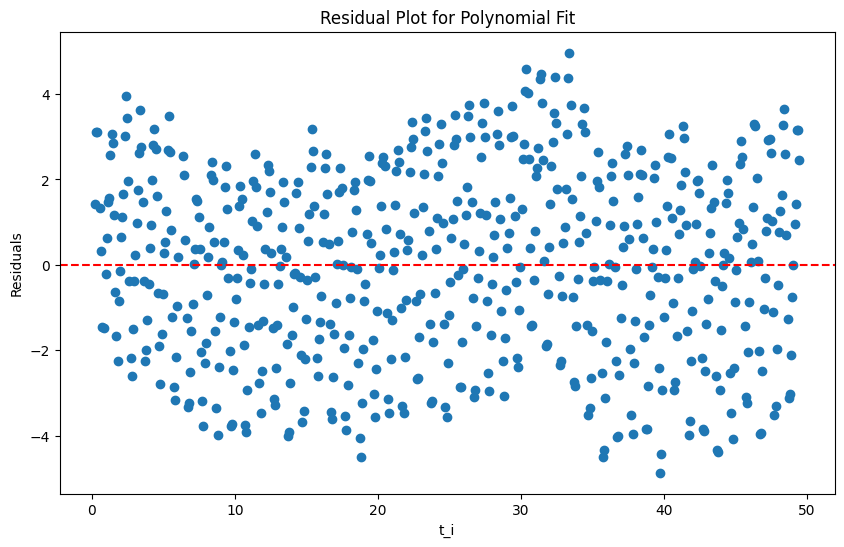

In [200]:
# prompt: plot residual error for the polynomial fit

import matplotlib.pyplot as plt
# Calculate residuals
residuals = y_train - model(X_train.flatten())

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(X_train, residuals)
plt.xlabel('t_i')
plt.ylabel('Residuals')
plt.title('Residual Plot for Polynomial Fit')
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.show()


In [201]:
# prompt: report the RMSE and the MAPE for the quadratic model

import numpy as np
# Predictions on the test set using the quadratic model
y_pred_poly = model(X_test.flatten())  # Flatten X_test for the polynomial model

# Calculating RMSE and MAPE for the quadratic model
rmse_poly = np.sqrt(mean_squared_error(y_test, y_pred_poly))
mape_poly = mean_absolute_percentage_error(y_test, y_pred_poly)

print(f'RMSE (Quadratic Model): {rmse_poly:.2f}')
print(f'MAPE (Quadratic Model): {mape_poly:.2%}')


RMSE (Quadratic Model): 2.50
MAPE (Quadratic Model): 0.53%


In [202]:
# prompt: subtract the quadratic model from df_cleaned

# Calculate the predictions for the entire dataset
y_pred_all = model(df_cleaned['t_i'].values)

# Subtract the quadratic model from the CO2 values
df_cleaned['CO2_detrended'] = df_cleaned['CO2'] - y_pred_all


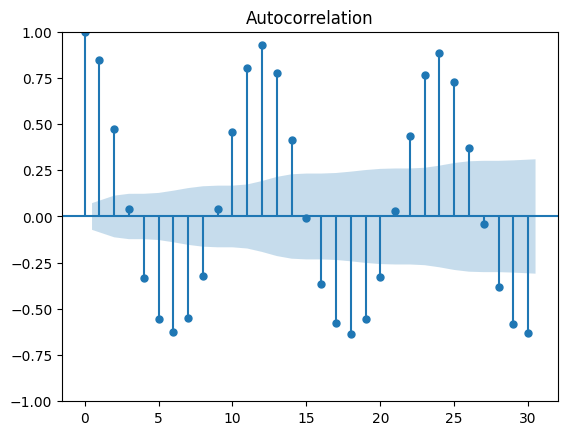

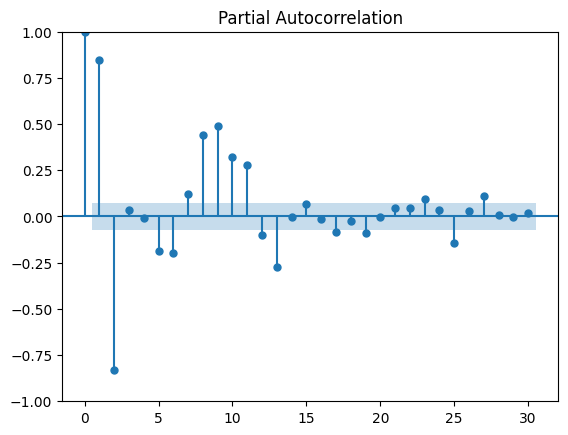

In [203]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(df_cleaned['CO2_detrended'], lags=30)
plt.show()
sm.graphics.tsa.plot_pacf(df_cleaned['CO2_detrended'], lags=30)
plt.show()


In [205]:
# prompt: join df and df_cleaned

import pandas as pd
# Assuming 't_i' is the common column between the two dataframes
df_merged = pd.merge(df, df_cleaned, on='t_i', how='left')
print(df_merged.head())


         Date   CO2_x  Mn       t_i   CO2_y  CO2_detrended
0   1958.0411  -99.99   1  0.041667     NaN            NaN
1   1958.1260  -99.99   2  0.125000     NaN            NaN
2   1958.2027  315.70   3  0.208333  315.70       1.431786
3   1958.2877  317.45   4  0.291667  317.45       3.114440
4   1958.3699  317.51   5  0.375000  317.51       3.106925


In [206]:
# prompt: drop rows with NaN values from df_merged

df_merged = df_merged.dropna()
print(df_merged.head())
print(df_merged.tail())


         Date   CO2_x  Mn       t_i   CO2_y  CO2_detrended
2   1958.2027  315.70   3  0.208333  315.70       1.431786
3   1958.2877  317.45   4  0.291667  317.45       3.114440
4   1958.3699  317.51   5  0.375000  317.51       3.106925
6   1958.5370  315.86   7  0.541667  315.86       1.321391
7   1958.6219  314.93   8  0.625000  314.93       0.323372
           Date   CO2_x  Mn        t_i   CO2_y  CO2_detrended
736   2019.3699  414.83   5  61.375000  414.83       5.855415
737   2019.4548  413.96   6  61.458333  413.96       4.794538
738   2019.5370  411.85   7  61.541667  411.85       2.493492
739   2019.6219  410.08   8  61.625000  410.08       0.532278
740   2019.7068  408.55   9  61.708333  408.55      -1.189105


In [207]:
# prompt: find the mean of the set of CO2_detrended where Mn = 1, Mn = 2, Mn = 3, etc.

# Group the DataFrame by 'Mn' and calculate the mean of 'CO2_detrended' for each group
mean_co2_detrended_by_mn = df_merged.groupby('Mn')['CO2_detrended'].mean()

# Print the result
print(mean_co2_detrended_by_mn)


Mn
1     0.179796
2     0.818816
3     1.501363
4     2.737018
5     3.211877
6     2.493964
7     0.872987
8    -1.244371
9    -3.036576
10   -3.211683
11   -1.933442
12   -0.769444
Name: CO2_detrended, dtype: float64


Include your answers to the following questions in your written report.

Problem 2: The final model

1. (3 points) Plot the periodic signal P_i. (Your plot should have 1 data point for each month, so 12 in total.) Clearly state the definition of P_i , and make sure your plot is clearly labeled.

Answer: The P_i function is a sine wave function that has been fit to values of each month's average CO2 levels, detrended from their quadratic trend.

Here is the graph:

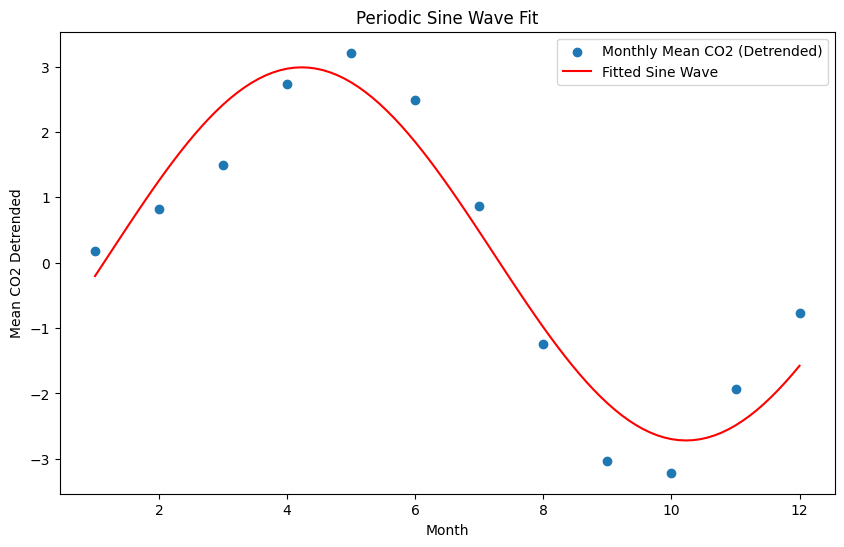

In [221]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# x values are the months (1 to 12)
x_data = np.array(range(1, 13))
# y values are the mean CO2 detrended values
y_data = mean_co2_detrended_by_mn.values

# Define the sine wave function
def sine_func(x, amplitude, phase_shift, vertical_shift):
  return amplitude * np.sin(1 / 12 * 2 * np.pi * (x - phase_shift)) + vertical_shift #Removed mean as it was not defined

# Fit the sine wave to the data
params, _ = curve_fit(sine_func, x_data, y_data)

# Extract the fitted parameters
amplitude, phase_shift, vertical_shift = params

# Generate x values for a smooth sine wave (for plotting)
x_smooth = np.linspace(1, 12, 100)
# Calculate the corresponding y values using the fitted sine wave, using x_smooth
y_smooth = sine_func(x_smooth, amplitude, phase_shift, vertical_shift) # Use x_smooth here

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(x_data, y_data, label='Monthly Mean CO2 (Detrended)')  # Plot the original mean values
plt.plot(x_smooth, y_smooth, color='red', label='Fitted Sine Wave')  # Plot the fitted sine wave
plt.xlabel('Month')
plt.ylabel('Mean CO2 Detrended')
plt.title('Periodic Sine Wave Fit')
plt.legend()
plt.show()

2. (2 points) Plot the final fit $F_n(T_i) + P_i$. Your plot should clearly show the final model on top of the entire time series, while indicating the split between the training and testing data.

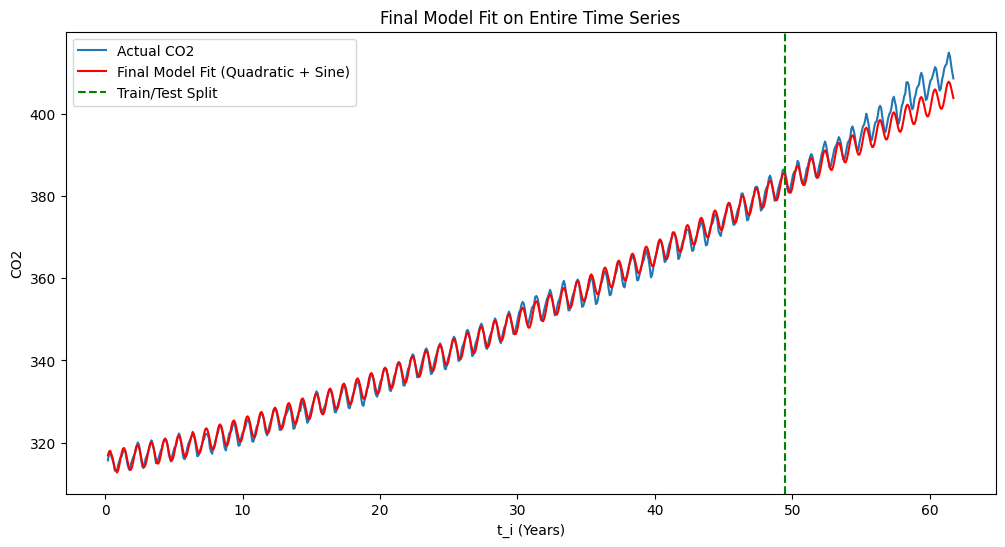

In [229]:
# prompt: take plt.plot(x_smooth, y_smooth, color='red', label='Fitted Sine Wave') and extend it, layer the plot over the plot of df_cleaned['CO2_detrended'], show a vertical line where X_train ends

import matplotlib.pyplot as plt
# Calculate the predictions for the entire dataset using both the quadratic and sine wave models
y_pred_all_final = model(df_cleaned['t_i'].values) + sine_func(df_cleaned['t_i'].values * 12 % 12, amplitude, phase_shift, vertical_shift)

# Plot the entire time series and the final model
plt.figure(figsize=(12, 6))
plt.plot(df_cleaned['t_i'], df_cleaned['CO2'], label='Actual CO2')
plt.plot(df_cleaned['t_i'], y_pred_all_final, color='red', label='Final Model Fit (Quadratic + Sine)')

# Indicate the split between training and testing data
plt.axvline(x=train_data['t_i'].iloc[-1], color='green', linestyle='--', label='Train/Test Split')

plt.xlabel('t_i (Years)')
plt.ylabel('CO2')
plt.title('Final Model Fit on Entire Time Series')
plt.legend()
plt.show()


In [230]:
# prompt: Report the root mean squared prediction error  and the mean absolute percentage error  with respect to the test set for this final model

import numpy as np
# Extract the test set predictions from the final model
y_pred_test_final = y_pred_all_final[train_data.shape[0]:]

# Calculate RMSE and MAPE for the final model on the test set
rmse_final = np.sqrt(mean_squared_error(y_test, y_pred_test_final))
mape_final = mean_absolute_percentage_error(y_test, y_pred_test_final)

print(f'RMSE (Final Model): {rmse_final:.2f}')
print(f'MAPE (Final Model): {mape_final:.2%}')


RMSE (Final Model): 3.49
MAPE (Final Model): 0.71%


In [231]:
# prompt: What is the ratio of the range of values of  F to the amplitude of  P_i and the ratio of the amplitude of  to the range of the residual  (from removing both the trend and the periodic signal)

import numpy as np
# Calculate the range of F_n(T_i)
range_F = np.ptp(y_pred_all)

# Calculate the range of the residuals (after removing trend and periodic signal)
residuals_final = df_cleaned['CO2'] - y_pred_all_final
range_residuals = np.ptp(residuals_final)

# Calculate the ratios
ratio_F_to_P = range_F / (2 * amplitude)  # Amplitude of sine wave is half the peak-to-peak range
ratio_P_to_residuals = (2 * amplitude) / range_residuals

print(f"Ratio of range of F to amplitude of P_i: {ratio_F_to_P:.2f}")
print(f"Ratio of amplitude of P_i to range of residuals: {ratio_P_to_residuals:.2f}")


Ratio of range of F to amplitude of P_i: 15.85
Ratio of amplitude of P_i to range of residuals: 0.51


Given Ratios:

Ratio of range of
𝐹
to amplitude of
$𝑃_
𝑖$
​
 : 15.85

This ratio indicates that the range of $CO_2$ concentration values (total variability) is significantly larger (about 15.85 times) than the amplitude of the periodic component
$𝑃_
𝑖$. This suggests that the overall range of $CO_2$ concentrations is quite large compared to the seasonal or periodic variations in the data.

Ratio of amplitude of
$𝑃_
𝑖$
  to range of residuals: 0.51

This ratio indicates that the amplitude of the periodic component
$𝑃_
𝑖$
  is about half (0.51 times) the range of the residuals. In other words, the seasonal or periodic variations contribute to about half of the remaining variability after removing the trend and other periodic components from the $CO_2$ concentration data.

# Meaningfulness of Decomposition

Interpretation: These ratios provide insights into the relative contributions of different components (trend, periodic, residuals) to the overall variation in $CO_2$ concentration data.

Usefulness: Such decomposition helps in understanding how much of the variability is due to long-term trends, seasonal variations, and irregular fluctuations (residuals). It allows researchers to focus on specific aspects of variability and their implications (e.g., seasonal health impacts, long-term environmental changes).

In summary, the provided ratios are meaningful as they quantify the relationships between the total range of $CO_2$ concentrations, periodic variations, and residual fluctuations, thereby aiding in the comprehensive analysis of the data's variability.

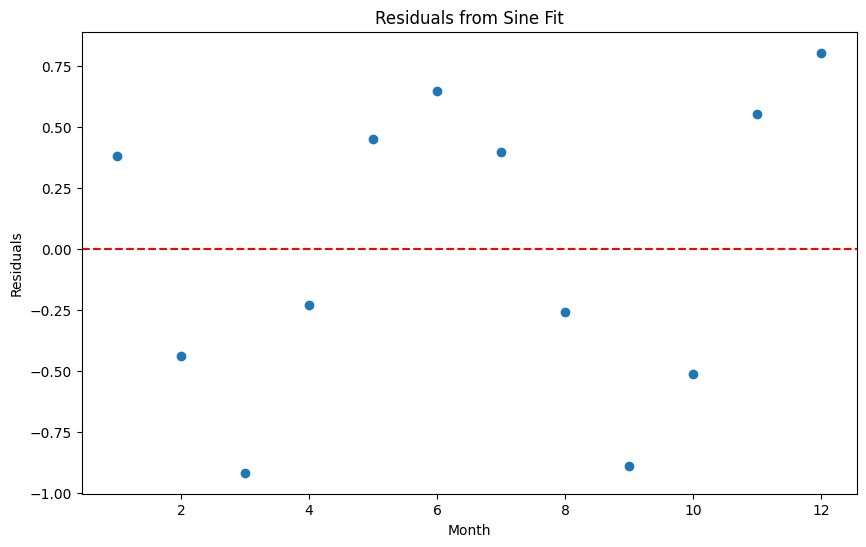

In [210]:
# prompt: plot the residuals

import matplotlib.pyplot as plt
# Calculate the residuals
residuals_sine = y_data - sine_func(x_data, amplitude, phase_shift, vertical_shift)

# Plot the residuals
plt.figure(figsize=(10, 6))
plt.scatter(x_data, residuals_sine)
plt.xlabel('Month')
plt.ylabel('Residuals')
plt.title('Residuals from Sine Fit')
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.show()


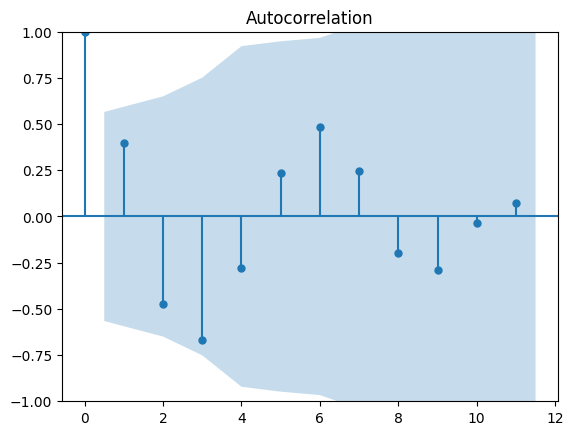

In [211]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(residuals_sine, lags = 11)
plt.show()

In [212]:
print(np.mean((residuals_sine)**2))

0.34131376716411604


In [216]:
# prompt: add 'sin_approx' to df_merged

import pandas as pd
# Assuming 'df_merged' and 'result_df' are already defined as in the preceding code

# Merge the two DataFrames on the 'x' column (assuming 't_i' in df_merged corresponds to 'x' in result_df)
df_merged = pd.merge(df_merged, result_df, left_on='t_i', right_on='x', how='left')

# You can now drop the 'x' column if it's not needed
df_merged = df_merged.drop('x', axis=1)

# Display the updated DataFrame
print(df_merged.head())


         Date   CO2_x  Mn       t_i   CO2_y  CO2_detrended  sin_approx
0   1958.2027  315.70   3  0.208333  315.70       1.431786    0.279612
1   1958.2877  317.45   4  0.291667  317.45       3.114440    0.278681
2   1958.3699  317.51   5  0.375000  317.51       3.106925    0.277475
3   1958.5370  315.86   7  0.541667  315.86       1.321391    0.274248
4   1958.6219  314.93   8  0.625000  314.93       0.323372    0.272233


In [217]:
# prompt: show first 60 rows of df_merged

print(df_merged.head(60))


          Date   CO2_x  Mn       t_i   CO2_y  CO2_detrended  sin_approx
0    1958.2027  315.70   3  0.208333  315.70       1.431786    0.279612
1    1958.2877  317.45   4  0.291667  317.45       3.114440    0.278681
2    1958.3699  317.51   5  0.375000  317.51       3.106925    0.277475
3    1958.5370  315.86   7  0.541667  315.86       1.321391    0.274248
4    1958.6219  314.93   8  0.625000  314.93       0.323372    0.272233
5    1958.7068  313.21   9  0.708333  313.21      -1.464816    0.269955
6    1958.8740  313.33  11  0.875000  313.33      -1.481697    0.264629
7    1958.9562  314.67  12  0.958333  314.67      -0.210389    0.261591
8    1959.0411  315.58   1  1.041667  315.58       0.630750    0.258310
9    1959.1260  316.48   2  1.125000  316.48       1.461720    0.254793
10   1959.2027  316.65   3  1.208333  316.65       1.562523    0.251047
11   1959.2877  317.72   4  1.291667  317.72       2.563157    0.247079
12   1959.3699  318.29   5  1.375000  318.29       3.063623    0

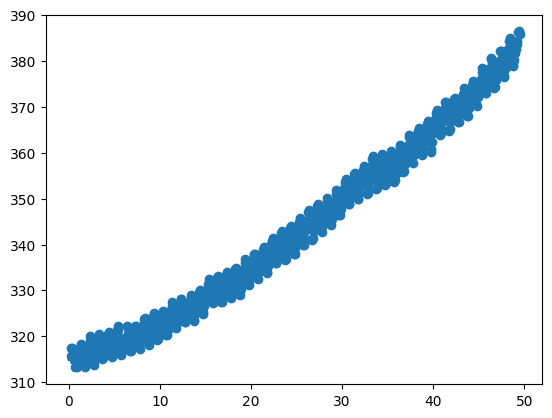

            3           2
-0.0001183 x + 0.02096 x + 0.6249 x + 314.9


In [218]:
# degree 3 polynomial fit or cubic fit
model = np.poly1d(np.polyfit(X_train.flatten(), # Use the X_train NumPy array and flatten it
                             y_train, 3))

# polynomial line visualization
polyline = np.linspace(0, 10, 100)
plt.scatter(X_train, y_train)
plt.plot(polyline, model(polyline))
plt.show()

print(model)

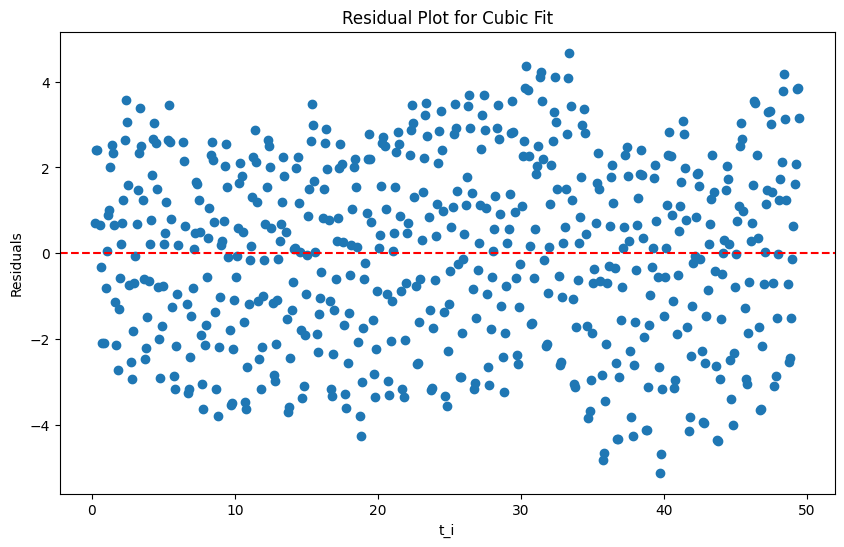

In [219]:
# prompt: residual plot for the cubic

import matplotlib.pyplot as plt
# Calculate residuals for the cubic model
residuals_cubic = y_train - model(X_train.flatten())

# Plot residuals for the cubic model
plt.figure(figsize=(10, 6))
plt.scatter(X_train, residuals_cubic)
plt.xlabel('t_i')
plt.ylabel('Residuals')
plt.title('Residual Plot for Cubic Fit')
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.show()


In [220]:
# prompt: find the RSPE and the MAPE for the cubic

import numpy as np
# Predictions on the test set using the cubic model
y_pred_cubic = model(X_test.flatten())

# Calculating RMSE, RSPE and MAPE for the cubic model
rmse_cubic = np.sqrt(mean_squared_error(y_test, y_pred_cubic))
rspe_cubic = np.sqrt(np.sum((y_test - y_pred_cubic)**2) / np.sum((y_test - np.mean(y_test))**2))
mape_cubic = mean_absolute_percentage_error(y_test, y_pred_cubic)

print(f'RMSE (Cubic Model): {rmse_cubic:.2f}')
print(f'RSPE (Cubic Model): {rspe_cubic:.2%}')
print(f'MAPE (Cubic Model): {mape_cubic:.2%}')


RMSE (Cubic Model): 4.15
RSPE (Cubic Model): 47.62%
MAPE (Cubic Model): 0.85%
